### Imports

In [1]:
from sentence_transformers import SentenceTransformer

c:\Users\maria\.conda\envs\embed\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sc

# Special imports for plots
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

### Creating the Dataframe and Loading in the Model

In [3]:
model = SentenceTransformer('mixedbread-ai/mxbai-embed-large-v1')

c:\Users\maria\.conda\envs\embed\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Embedding the text

In [7]:
'''
df = pd.read_csv('motivation_results.csv')
embedding = model.encode(df["Response"])
embedding = embedding.tolist()
embedding = np.array(embedding)
np.save('embeddings.npy', embedding)
'''

'\ndf = pd.read_csv(\'motivation_results.csv\')\nembedding = model.encode(df["Response"])\nembedding = embedding.tolist()\nembedding = np.array(embedding)\nnp.save(\'embeddings.npy\', embedding)\n'

In [35]:
df = pd.read_csv("motivation_results.csv")
embedding = np.load('embeddings.npy')
embedding = embedding.tolist()
df.insert(1,"embedding",embedding)

In [36]:
df.head()

,Response,embedding,Codes,physiological/emotional,Vicarious,Mastery,Social Persuasion,Utility Value,Media Triggered,Event Triggered,Intrinsic Value,Intrinsic Value (Astronomy),Attainment Value,Intrinsic Social,Cost (Emotional),Cost (Outside Effort),Cost (Loss),Cost (Task Effort),Unnamed: 17
0,From the very beginning I had a love for math ...,"[0.38071826100349426, -0.26727038621902466, -0...","Intrinsic Value, Physiological/Emotional, Cost...",1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,NaN
1,I first took a physics class in my junior year...,"[0.05751581862568855, -0.43942421674728394, -0...","Vicarious Experience, Intrinsic Value, Cost (L...",0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,NaN
2,I first considered physics as a major when I t...,"[0.5500103831291199, -0.7009711265563965, -0.0...","Physiological/Emotional, Social Persuasion, Ma...",1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,NaN
3,"Ever since I was a freshman in high school"","" ...","[-0.296572208404541, -0.2284899652004242, -0.2...","Vicarious Experience, Social Persuasion, Intri...",0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,NaN
4,I had always wanted to become an astronaut as ...,"[-0.2757393419742584, -0.064843088388443, -0.1...","Utility Value, Intrinsic Value (Astronomy)",0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,NaN


In [31]:
df = df.drop(499)
df = df.reset_index(drop=True)

In [34]:
text_embeddings = np.vstack(df["embedding"].values)
print(text_embeddings.shape)

(2124, 1024)


### Defining the centroids

In [39]:
centroid_indices = [[1,296,370,378,825],
                    [9,389,488,514,817],
                    [37,519,646,736,312],
                    [26,734,813,384,361],
                    [151,208,210,243,818],
                    [22,792,782,613,383]]
category_names = ["Attainment Value", "Cost", "Intrinsic Value", "Media Triggered Intrinsic Value", 
                  "Event Triggered Intrinsic Value", "Intrinsic Value (Social)", "Utility Value", "Mastery Experience", 
                  "Physiological or Emotional Arousal", "Social Persuasion", "Vicarious Experience"]

In [41]:
centroid_embeddings = []

for category in centroid_indices:
  category_embeddings = []
  for index in category: category_embeddings.append(df.embedding[index])
  category_embedding_centroid = np.mean(category_embeddings, axis=0)
  centroid_embeddings.append(category_embedding_centroid)

centroid_embeddings = np.array(centroid_embeddings)

In [42]:
print(centroid_embeddings)

[[ 0.48241176 -0.05231127 -0.28079841 ... -0.52812949 -0.28377021
   0.59898394]
 [-0.33882855  0.24397615  0.13973416 ... -0.30720583 -0.11197303
   0.13275815]
 [ 0.06159831  0.25616207  0.16241201 ... -0.11318934 -0.15458595
  -0.03366916]
 [-0.29312088 -0.25183946 -0.77301881 ... -0.81449322 -0.25483154
   0.12657737]
 [-0.16190544  0.34683324 -0.50198736 ... -0.50531387  0.13643485
   0.52299857]
 [ 0.43447202 -0.02266225 -0.28385627 ... -0.33436612 -0.140189
   0.07888806]]


### Scoring

In [43]:
def embedding_score(text_embeddings, centroid_embeddings, alpha, metric, scaling, rounding=False):

    # Check that the input is valid
    assert scaling in ["exponential", "power"]
    assert metric in ["cosine", "euclidean", "cityblock"]

    # Calculating distances using scipy.spatial.distance.cdist function
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
    distances = sc.spatial.distance.cdist(text_embeddings, centroid_embeddings, metric=metric)

    # Scale and invert the distances according to the specified scaling
    if scaling == "exponential":
        score = 1/np.exp(alpha*distances)
    if scaling == "power":
        score = 1/(distances**alpha)

    # L1 norm the scores to get a probability distribution
    score /= score.sum(axis=1)[:,None]

    # Round the scores to 2 decimals if specified
    if rounding:
        # Set all values below 0.01 to 0
        score[score <=0.01] = 0
        score /= score.sum(axis=1)[:,None]

    return score

#### Scoring with $\alpha = 1$

In [44]:
texts = text_embeddings   # the matrix of all the embeddings from earlier
centroids = centroid_embeddings   # the embedded centroids we made in part 3

alpha = 1    # an initial alpha value
metric = 'cosine'   # Cosine Similarity
scaling = 'power'   # Power scaling

scores = embedding_score(texts, centroids, alpha, metric, scaling)

print(scores[:5])

[[0.22512175 0.16665603 0.15603347 0.15343512 0.14607583 0.1526778 ]
 [0.3225463  0.16801276 0.14424265 0.12449654 0.12326744 0.11743432]
 [0.17953407 0.22823064 0.16153216 0.14955023 0.13919104 0.14196186]
 [0.21038233 0.19180421 0.17452778 0.13940203 0.14113212 0.14275153]
 [0.17702462 0.18589902 0.16646925 0.15759757 0.15531219 0.15769735]]


#### Scoring with $\alpha = 50$

In [103]:
texts = text_embeddings   # the matrix of all the embeddings from earlier
centroids = centroid_embeddings   # the embedded centroids we made in part 3

alpha = 50    # an initial alpha value
metric = 'cosine'   # Cosine Similarity
scaling = 'power'   # Power scaling

In [104]:
scores = embedding_score(texts, centroids, alpha, metric, scaling)

print(np.shape(scores))

(828, 6)


### Assigning the categories

We take the scores given, then use this to assign the "most likely" category for each value.

#### $\alpha=150$

We set $\alpha = 150$ to force each value to only be assigned to one category. 

In [109]:
scores = embedding_score(texts, centroids, alpha=150, metric='cosine', scaling='power')

In [110]:
def score_picker(score, len_val_list):
    '''
    Docstring - have to write more
    len_val_list refers to the number of values one wishes to use
    '''
    single_score = np.zeros(len_val_list)
    category = np.zeros_like(single_score)

    for i in range(len(single_score)): 
        max_index = np.argmax(score[i])
        max_val = score[i][max_index]

        single_score[i] = max_val
        category[i] = max_index

    return single_score, category

val_score, category_list = score_picker(scores, 500)

### $\alpha = 15$

We set $\alpha=15$ and exclude the values where the certainty of the biggest category is less than $0.50$:

In [111]:
scores = embedding_score(texts, centroids, alpha=15, metric='cosine', scaling='power')

In [116]:
def score_picker_excluded(score, len_val_list):
    '''
    Docstring - have to write more
    len_val_list refers to the number of values one wishes to use
    '''
    category_excluded = np.zeros(len_val_list)
    for i in range(len(category_excluded)): 
        max_index = np.argmax(score[i])
        max_val = score[i][max_index]

        if max_val < 0.50:
            category_excluded[i] = -1
        else:
            category_excluded[i] = max_index

    return category_excluded

category_ex = score_picker_excluded(scores, 500)

In [118]:
df = pd.DataFrame(category_list)
df_2 = pd.DataFrame(category_ex)

# Save the DataFrame to a CSV file
df.to_csv('embed_news_dataset.csv', index=False, header=False)
df_2.to_csv('embed_news_excluded.csv', index=False, header=False)

### Heatmap

In [48]:
# @title Plotting function for heatmap
def plot_heatmap(indices, alpha, metric, scaling, category_names):
    import string
    alphabet = list(string.ascii_lowercase)

    red_colors = [(1, 0.95, 0.95), (1, 0.9, 0.9), (1, 0.4, 0.5),
                  (0.95, 0.3, 0.4), (0.95, 0.2, 0.3), (0.7, 0.1, 0.2),
                   (0.5, 0.08, 0.15)]
    red_cmap = mcolors.LinearSegmentedColormap.from_list("custom", red_colors, N=256)

    # Plot heatmaps for all five articles as subplots in one figure
    fig, ax = plt.subplots(len(indices),1, figsize=(10, len(indices)+2))
    embedding_scores = embedding_score(text_embeddings, centroid_embeddings, alpha, metric, scaling)

    # Create each of the subplot heatmaps
    for i, index in enumerate(indices):
        scores = np.vstack(embedding_scores[index, :]).T
        gx = sns.heatmap(scores, cmap=red_cmap, annot=True, yticklabels=['Score'],
                         xticklabels=range(1,len(category_names)+1), vmin=0, vmax=1, ax=ax[i], cbar=False, fmt='.2f')

        # extra formating of the plot
        gx.set_yticklabels(gx.get_yticklabels(), fontsize=9)
        ax[i].text(-0.3, -0.2, f"({alphabet[i]})", fontsize=11, fontweight='bold')

        # This line might need changes in order to be more usefull
        ax[i].set_title(f'{df["Title"][index]}', fontweight='bold', fontsize=10)


    legend_patches = [mpatches.Patch(color='white', label=(f'{i+1}: {category}')) for i, category in enumerate(category_names)]
    fig.legend(handles=legend_patches, bbox_to_anchor=(1.05, 0.95), loc='upper left', frameon = False, ncol=1, prop={'size': 10, 'weight':'bold'})
    fig.tight_layout(w_pad=2, h_pad=2)
    plt.show()


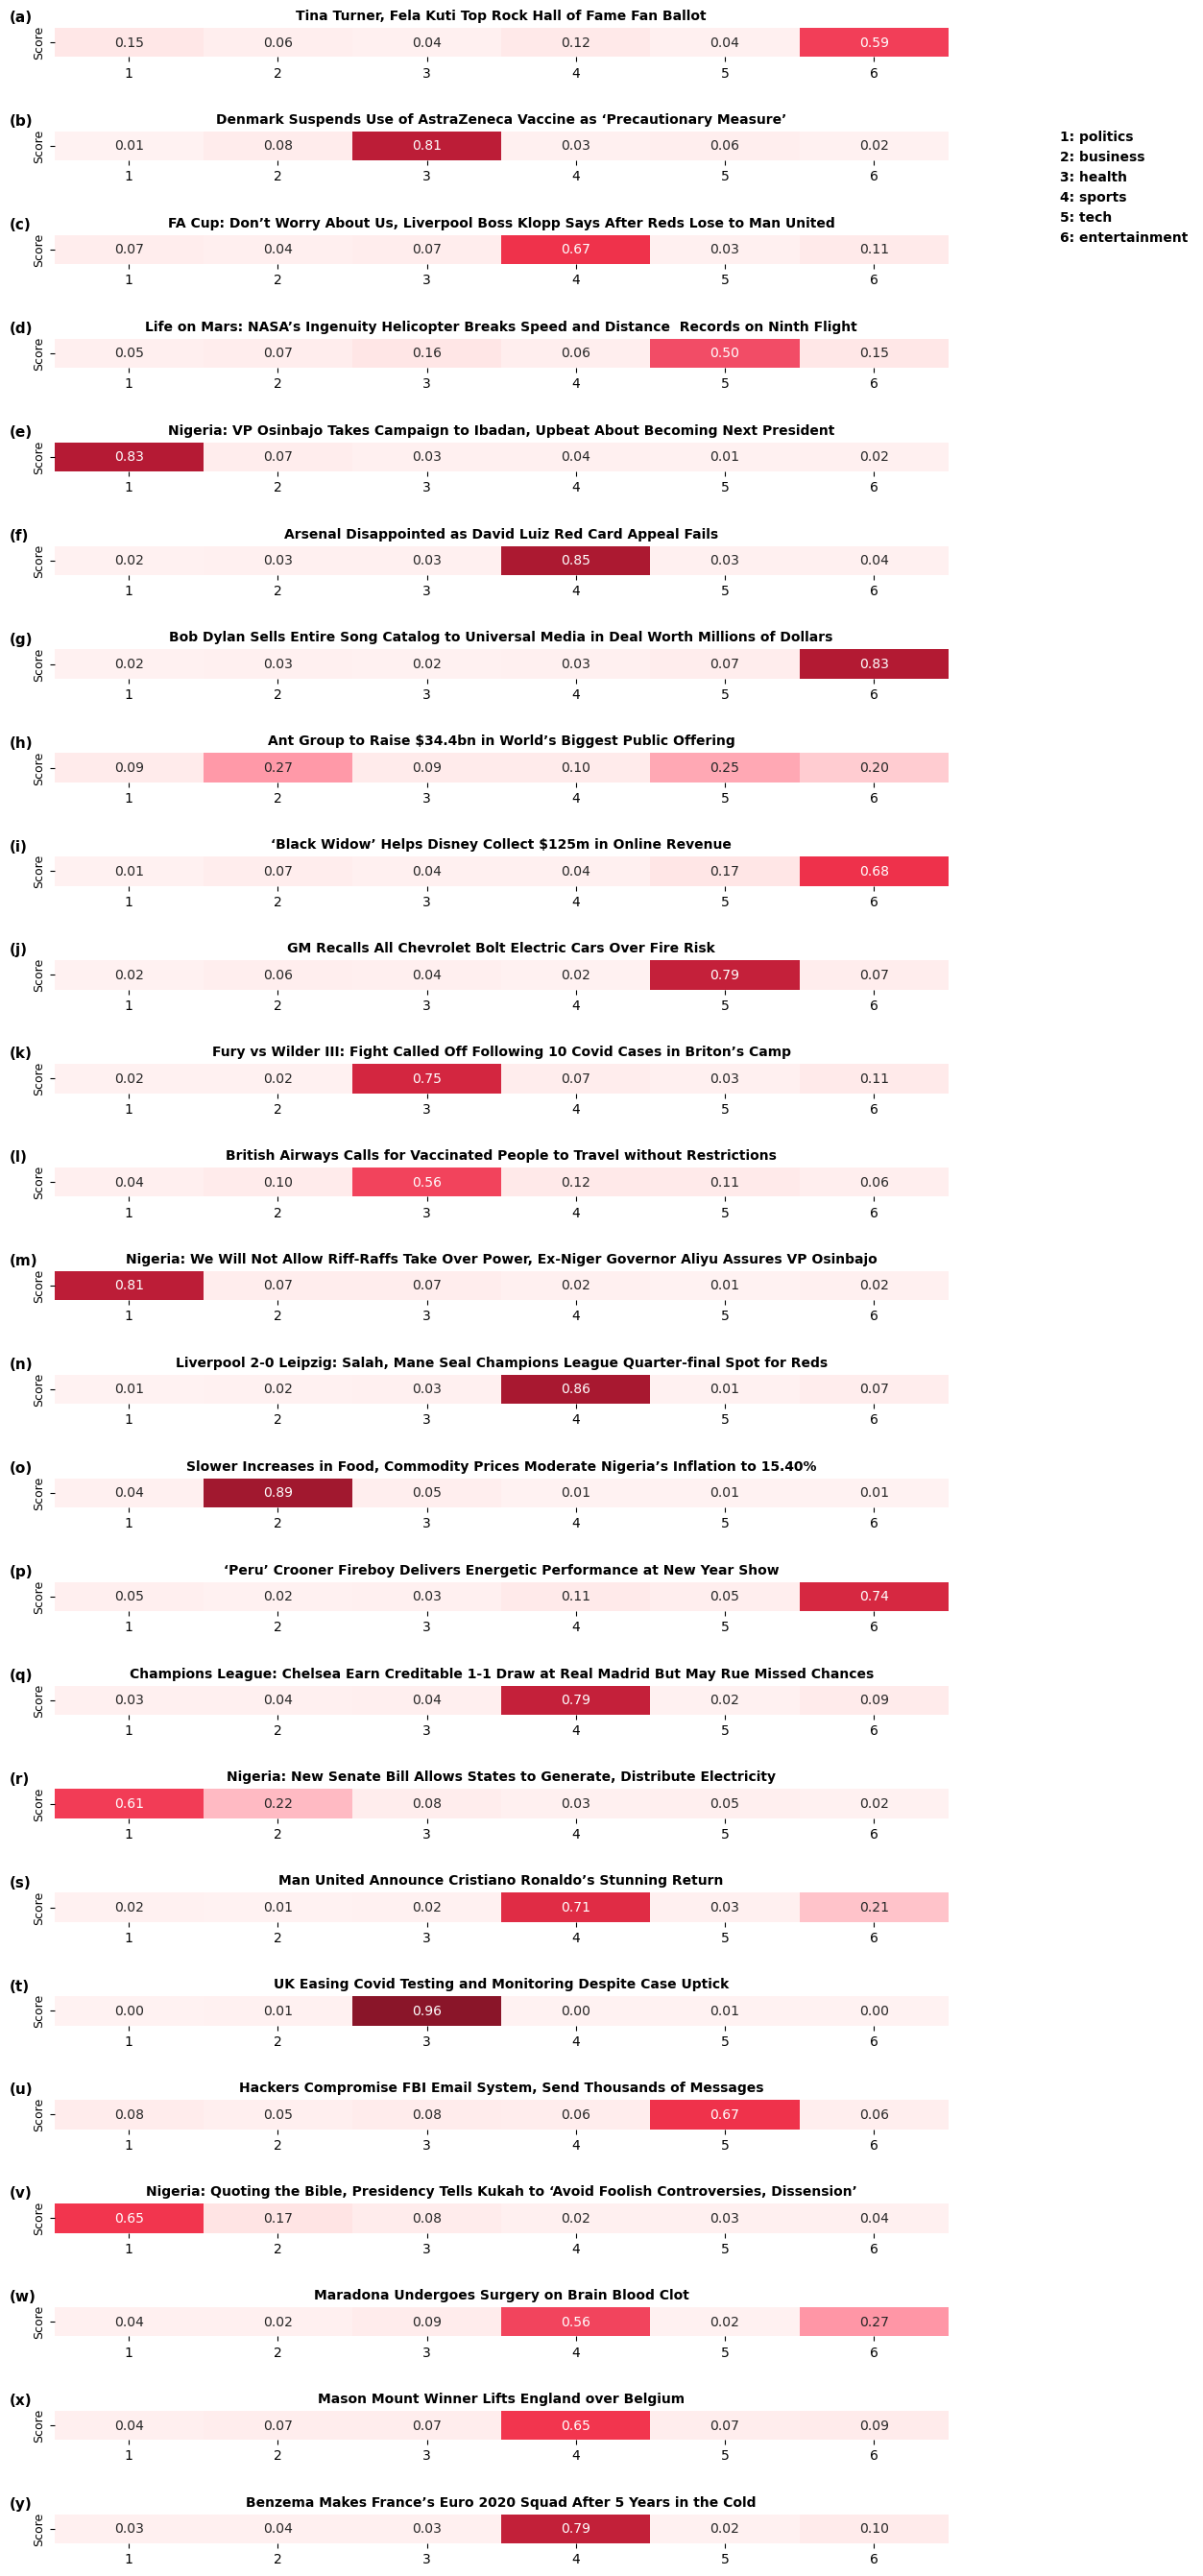

In [49]:
plot_heatmap(list(range(500,525)), 15, 'cosine', 'exponential', category_names)

### Pie Chart

In [50]:
alpha = 10
metric = 'cosine'
scaling = 'exponential'

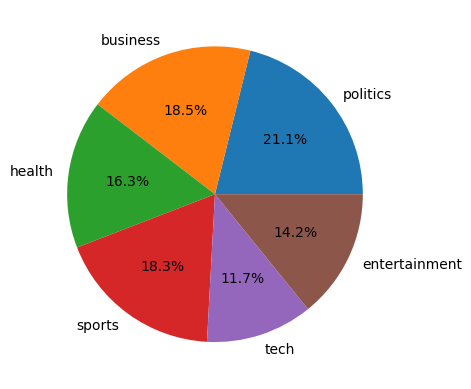

In [51]:
scores = embedding_score(text_embeddings, centroid_embeddings, alpha, metric, scaling)
aggregate=np.sum(scores, axis=0)

plt.pie(aggregate, labels=category_names, autopct="%1.1f%%")
plt.show()